Criar um modelo de regressao para prever os custos médicos individuais cobrados pela seguradora

# link do vídeo com a explicação do código
https://www.youtube.com/watch?v=3_fr9svsYlo

# link da base de dados original
https://www.kaggle.com/datasets/mirichoi0218/insurance

In [1]:
import pandas as pd

df = pd.read_csv("insurance.csv")
print(df.describe())
df.head()

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Podemos ver que nossos dados não possuem dados nulos, porem os campos "sex", "smoker" e "region" são colunas categóricas, portanto precisaremos converter para númericas

Então vamos usar o labelEncoder nas colunas sex e smoker, pois sao binarias, já na coluna region, usaremos onehotencoder para quebrar em cada região distinta

In [3]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df_num = df.copy()
df_num = pd.get_dummies(df,prefix="region", columns=["region"])

df_num['sex'] = labelEncoder.fit_transform(df['sex'])
df_num['smoker'] = labelEncoder.fit_transform(df['smoker'])


df_num.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


Podemos ver que a escala dos valores sao bem distintas entre as colunas, charges possui um valor bem alto, provavelmente é o valor anual das despesas

O que torna ela a coluna alvo

## Vamos analisar alguns gráficos:

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

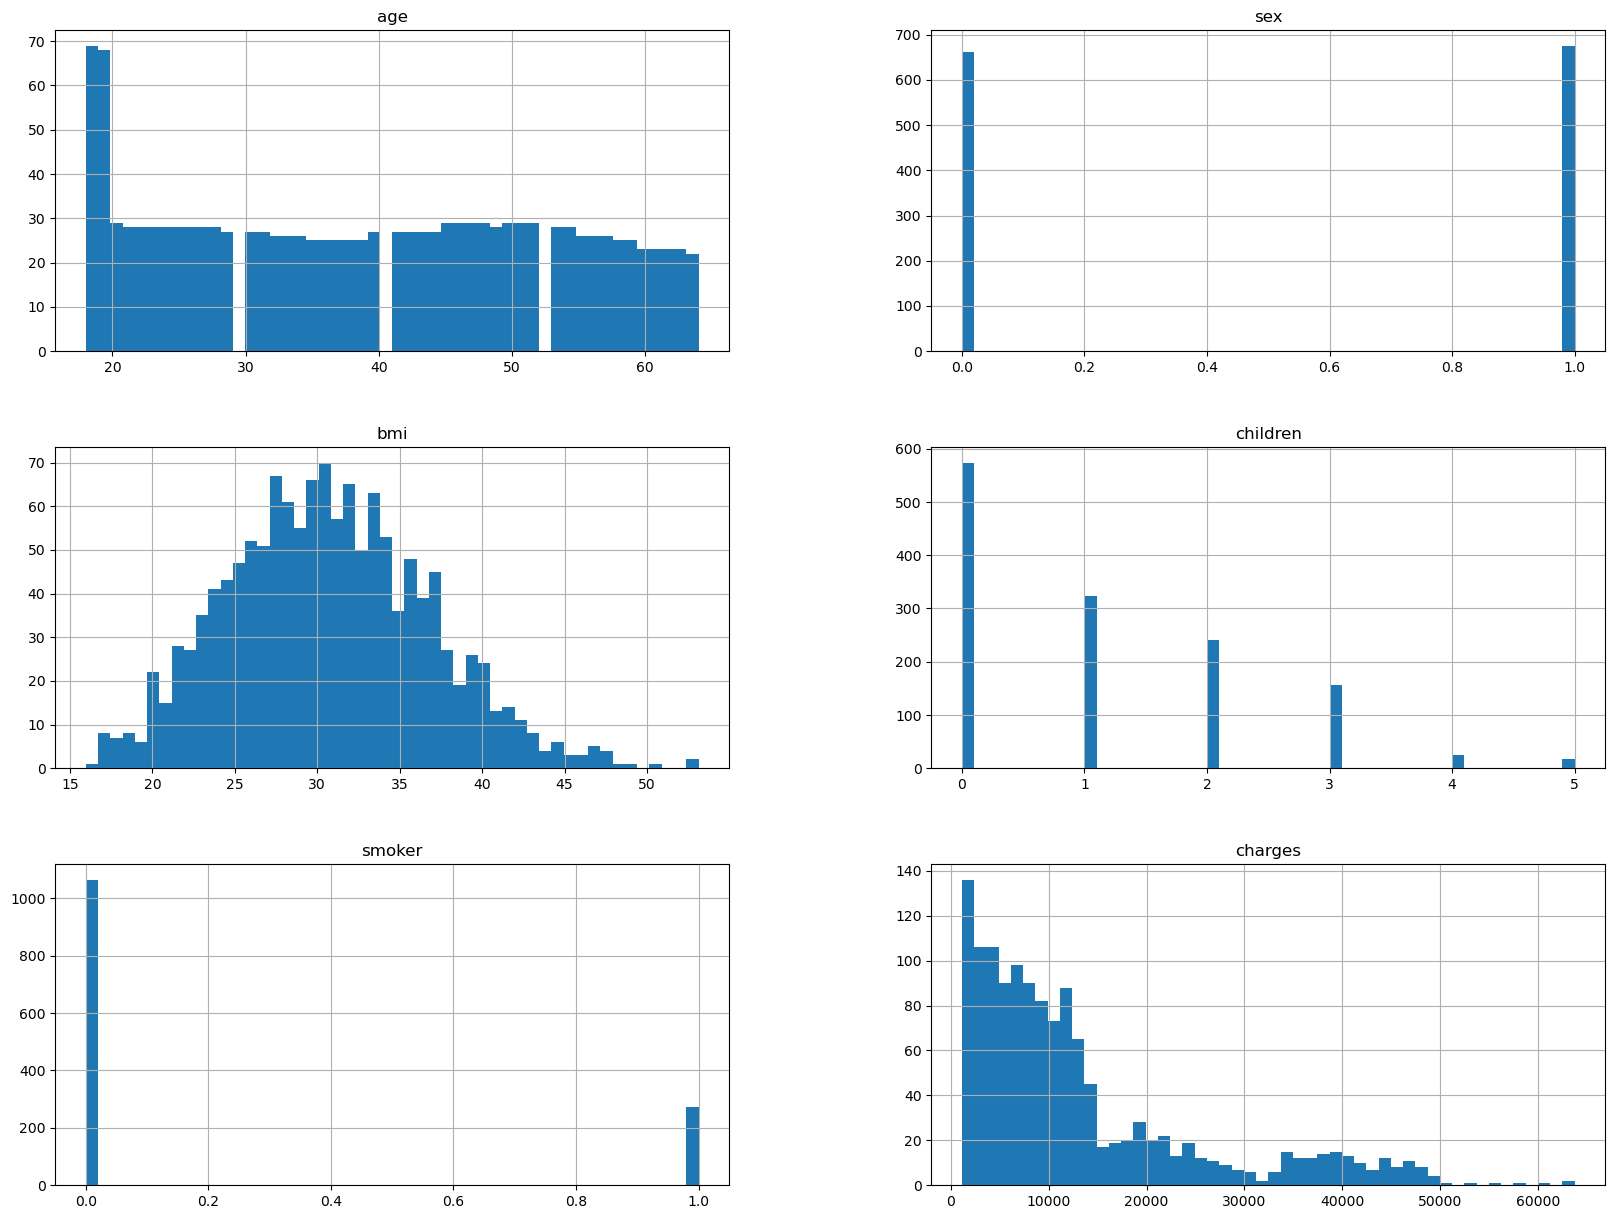

In [4]:
df_num.hist(bins=50, figsize=(20,15))

Temos uma grande quantidade de pessoas com 18 e 19 anos, é possivel que as pessoas menores de idade tenham sido alteradas para cortar em 18 anos

A distribuição entre os sexos e as regioes estao bem equilibradas

In [5]:
df_num.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

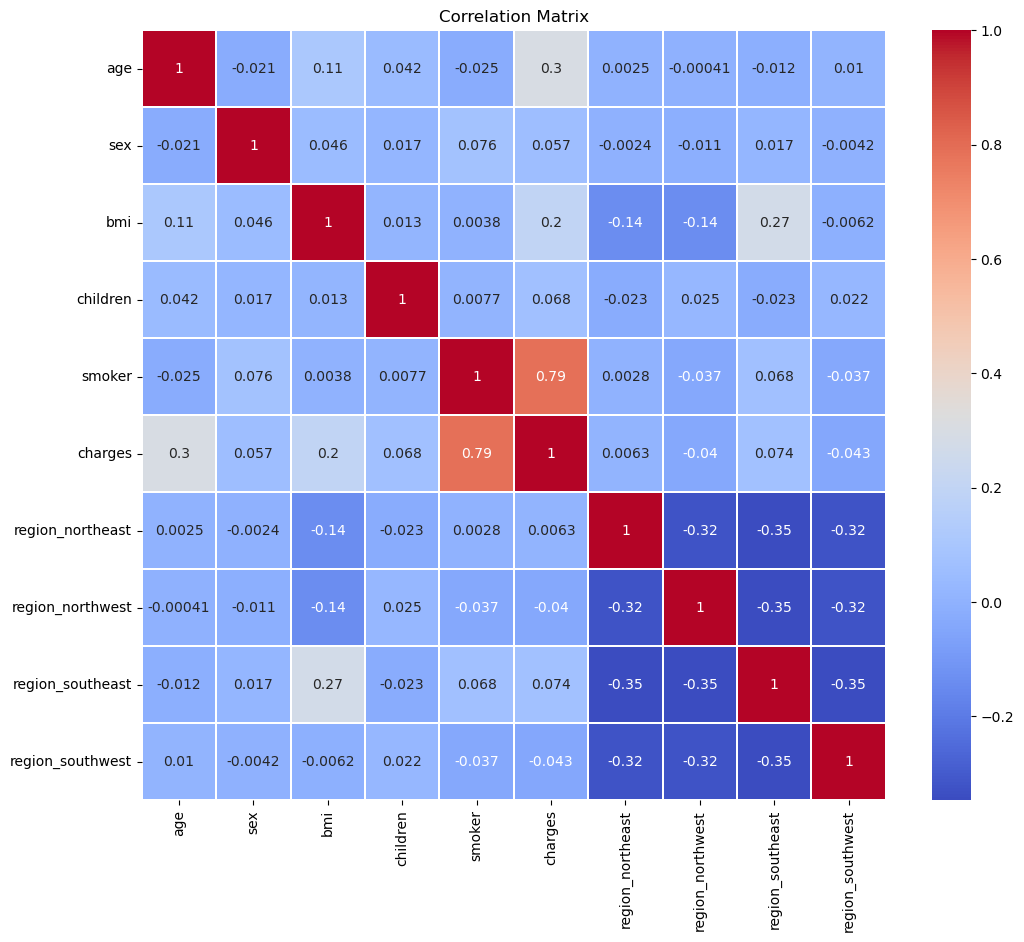

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(df_num.corr(), cmap='coolwarm', annot=True, linewidths=.1)
plt.title('Correlation Matrix')
plt.show()

A correlação mais relevante entre a coluna charges e as outras é com a smoker
Age e bmi, parecem influenciar um pouco tambem

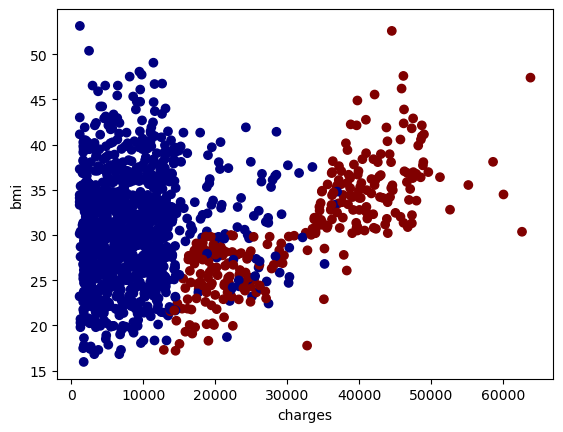

In [7]:
plt.scatter(df_num['charges'], df_num['bmi'], c=df_num['smoker'], cmap=plt.get_cmap("jet"))
plt.xlabel('charges')
plt.ylabel("bmi")
plt.show()

podemos ver melhor que os fumantes possuem contas mais altas

<Axes: xlabel='region', ylabel='charges'>

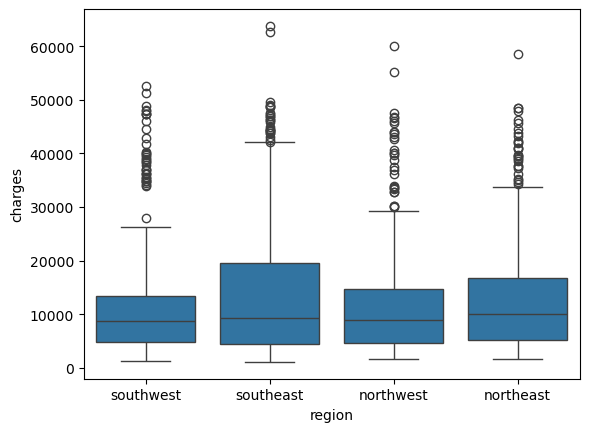

In [8]:
sns.boxplot(data=df, x='region', y='charges')

Aparentemente os valores não mudam muito de acordo como a regiao

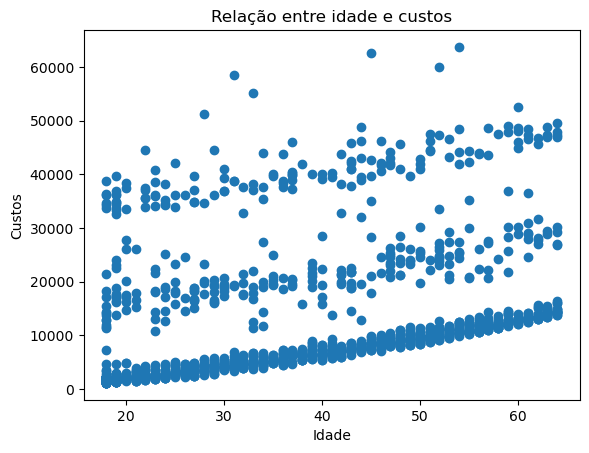

In [9]:
# Relação entre idade e valores
plt.scatter(df['age'], df['charges'])
plt.xlabel('Idade')
plt.ylabel('Custos')
plt.title('Relação entre idade e custos')
plt.show()

Segundo o diagrama acima, quanto maior a idade maior o custo, seguindo grupos de detereminadas faixas de custo, com algumas exceções, provavelmete uma certa quantidade de pessoas com doenças que exigem um tratamento mais caro.

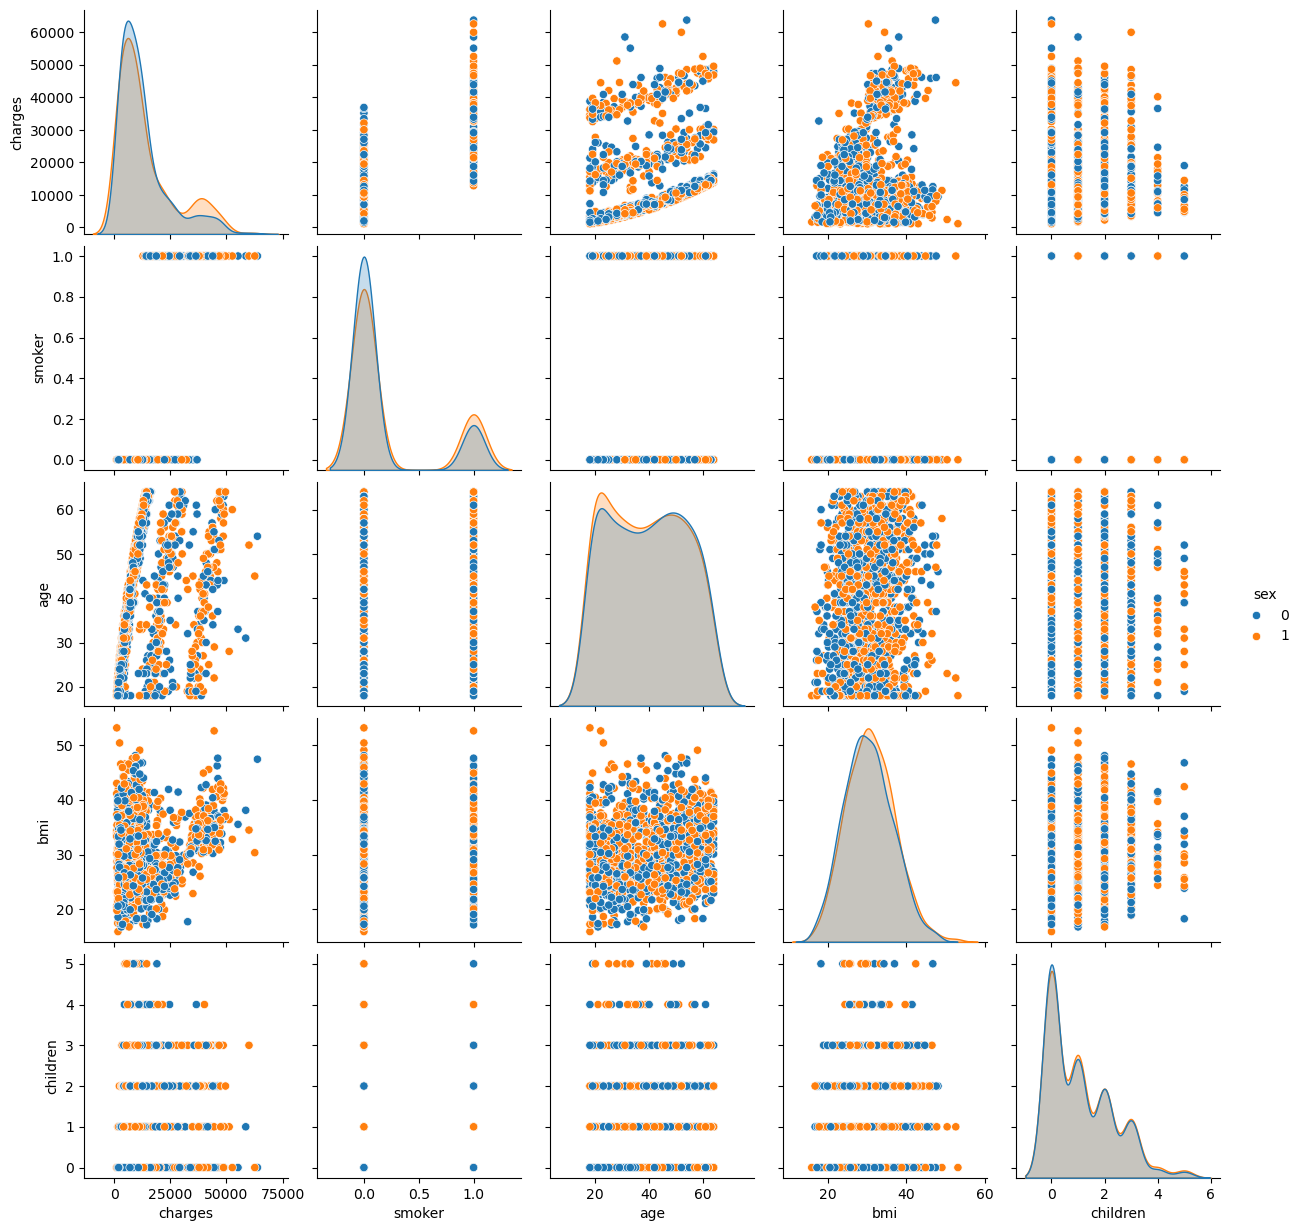

In [10]:
sns.pairplot(data=df_num,vars=['charges','smoker','age','bmi','children'],hue="sex")

Vamos separar os dados em teste e treino para poder escalonar

Primeiramente estratificando os dados entre fumantes e nao fumantes para garantir que as bases de treino e teste tenham as mesmas porcentagens de dados.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['smoker']):
    strat_train_set = df_num.loc[train_index]
    strat_test_set = df_num.loc[test_index]

rel_train = strat_train_set['smoker'].value_counts() / len(strat_train_set)
rel_test = strat_test_set['smoker'].value_counts() / len(strat_test_set)
print(f'relacao fumante nao fumante de treino {rel_train}')
print(f'relacao fumante nao fumante de teste {rel_test}')

relacao fumante nao fumante de treino smoker
0    0.795327
1    0.204673
Name: count, dtype: float64
relacao fumante nao fumante de teste smoker
0    0.794776
1    0.205224
Name: count, dtype: float64


In [12]:
X_train = strat_train_set.drop('charges', axis=1)
y_train = strat_train_set['charges']

X_test = strat_test_set.drop('charges', axis=1)
y_test = strat_test_set['charges']


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)
x_test_scaled = scaler.transform(X_test)

Vamos fazer a regressão nos dados sem o escalonamento e depois com para comparar

In [14]:
#treinando o modelo sem escalonamento e validando as metricas
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(X_train, y_train)

predictions = linReg.predict(X_test)

from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score

rms = root_mean_squared_error(y_test, predictions)
print(f"rms: {rms:.3f}")
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"MAPE: {mape:.3f}")
r2 = r2_score(y_test, predictions)
print(f"R2: {r2:.3f}")

print("Coefficients:", linReg.coef_)
print("Intercept:", linReg.intercept_)

rms: 5581.332
MAPE: 0.382
R2: 0.789
Coefficients: [  258.41903422  -240.27218606   324.67424821   495.06633367
 23859.0956788    644.25547721   204.25799214  -629.65753469
  -218.85593466]
Intercept: -12109.496905691369


O valor do MAPE e RMS deve ser o menor possível, enquanto o R2, deve se aproximar de 1

In [15]:
#Treinando o modelo escalonado e verificando as métricas
linReg_scaled = LinearRegression()
linReg_scaled.fit(x_train_scaled, y_train)

predictions_scaled = linReg_scaled.predict(x_test_scaled)

rms_scaled = root_mean_squared_error(y_test, predictions_scaled)
print(f"rms: {rms_scaled:.3f}")
mape_scaled = mean_absolute_percentage_error(y_test, predictions_scaled)
print(f"MAPE: {mape_scaled:.3f}")
r2_scaled = r2_score(y_test, predictions_scaled)
print(f"R2: {r2_scaled:.3f}")
print("Coefficients:", linReg_scaled.coef_)
print("Intercept:", linReg_scaled.intercept_)


rms: 5581.332
MAPE: 0.382
R2: 0.789
Coefficients: [3625.96896584 -120.11909292 1962.08780136  598.89014469 9626.24783101
  281.57414852   92.13401709 -275.47941385  -88.98253594]
Intercept: 13285.111926643927


Não houve nenhuma diferença de performance entre o treino escalonado e a não escalonado para a regressão linear

porém podemos ver que o intercept e os coeficientes estão diferentes, garantindo que houve diferença nas bases de dados

In [16]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)

tree.fit(X_train, y_train)

dt_predict = tree.predict(X_test)

dt_rms = root_mean_squared_error(y_test, dt_predict)
print(f"rms: {dt_rms:.3f}")
dt_mape = mean_absolute_percentage_error(y_test, dt_predict)
print(f"MAPE: {dt_mape:.3f}")
r2 = r2_score(y_test, predictions)
print(f"R2: {r2:.3f}")

rms: 5981.068
MAPE: 0.395
R2: 0.789


In [17]:
tree_scaled = DecisionTreeRegressor(random_state=42)

tree_scaled.fit(x_train_scaled, y_train)

dt_predict_scaled = tree_scaled.predict(x_test_scaled)

dt_rms_scaled = root_mean_squared_error(y_test, dt_predict_scaled)
print(f"rms: {dt_rms_scaled:.3f}")
dt_mape_scaled = mean_absolute_percentage_error(y_test, dt_predict_scaled)
print(f"MAPE: {dt_mape_scaled:.3f}")
r2_scaled = r2_score(y_test, dt_predict_scaled)
print(f"R2: {r2_scaled:.3f}")

rms: 5840.060
MAPE: 0.367
R2: 0.769


A árvore de decisão funcionou melhor usando a base de dados não escalonada

In [18]:
from sklearn.linear_model import BayesianRidge

br_model = BayesianRidge()

br_model.fit(X=X_train, y=y_train)
br_prediction = br_model.predict(X=X_test)

br_rms = root_mean_squared_error(y_test, br_prediction)
print(f"rms: {br_rms:.3f}")
br_mape = mean_absolute_percentage_error(y_test, br_prediction)
print(f"MAPE: {br_mape:.3f}")
br_r2 = r2_score(y_test, br_prediction)
print(f"R2: {br_r2:.3f}")

print("Coefficients:", br_model.coef_)
print("Intercept:", br_model.intercept_)

rms: 5581.221
MAPE: 0.383
R2: 0.789
Coefficients: [  258.3482076   -236.32571936   324.52316951   494.89764656
 23784.70516733   642.4135383    202.35670474  -624.28708601
  -220.48315703]
Intercept: -12088.827659319559


In [19]:
br_model_scaled = BayesianRidge()

br_model_scaled.fit(X=x_train_scaled, y=y_train)
br_prediction_scaled = br_model_scaled.predict(X=x_test_scaled)

br_rms_scaled = root_mean_squared_error(y_test, br_prediction_scaled)
print(f"rms: {br_rms_scaled:.3f}")
br_mape_scaled = mean_absolute_percentage_error(y_test, br_prediction_scaled)
print(f"MAPE: {br_mape_scaled:.3f}")
br_r2_scaled = r2_score(y_test, br_prediction_scaled)
print(f"R2: {br_r2_scaled:.3f}")

print("Coefficients:", br_model.coef_)
print("Intercept:", br_model.intercept_)

rms: 5581.389
MAPE: 0.383
R2: 0.789
Coefficients: [  258.3482076   -236.32571936   324.52316951   494.89764656
 23784.70516733   642.4135383    202.35670474  -624.28708601
  -220.48315703]
Intercept: -12088.827659319559


Como o knn é sensivel a distâncias, não faz sentido usar dados não escalonados a seguir:

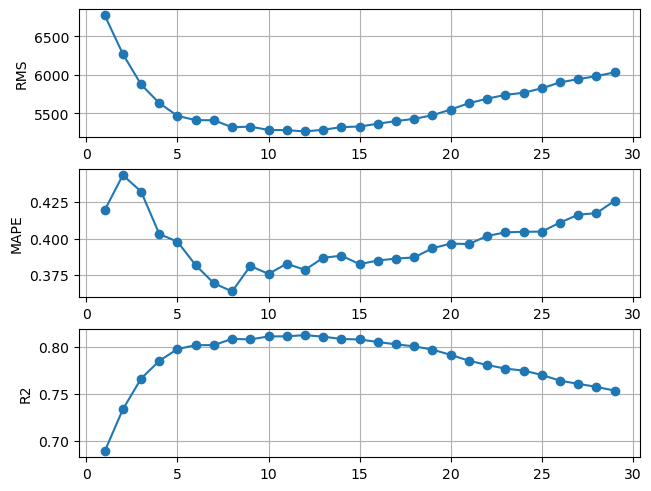

In [20]:
from sklearn.neighbors import KNeighborsRegressor
r2list=[]
mapelist=[]
rmslist =[]

k = range(1,30)

for i in k:
    knn_model = KNeighborsRegressor(n_neighbors=i)
    knn_model.fit(X=x_train_scaled, y=y_train)
    knn_prediction = knn_model.predict(X=x_test_scaled)

    knn_rms = root_mean_squared_error(y_test, knn_prediction)
    rmslist.append(knn_rms)

    knn_mape = mean_absolute_percentage_error(y_test, knn_prediction)
    mapelist.append(knn_mape)

    knn_r2 = r2_score(y_test, knn_prediction)
    r2list.append(knn_r2)


fig, axs = plt.subplots(3, 1, layout='constrained')
axs[0].plot(k, rmslist, "-o")
axs[0].set_ylabel('neighbors')
axs[0].set_ylabel('RMS')
axs[0].grid(True)

axs[1].plot(k, mapelist, "-o")
axs[1].set_ylabel('neighbors')
axs[1].set_ylabel('MAPE')
axs[1].grid(True)

axs[2].plot(k, r2list, "-o")
axs[2].set_ylabel('neighbors')
axs[2].set_ylabel('R2')
axs[2].grid(True)
plt.show()


De acordo com o gráfico, encontramos o melhor modelo com 12 vizinhos

In [21]:
knn_12_model = KNeighborsRegressor(n_neighbors=12)
knn_12_model.fit(X=x_train_scaled, y=y_train)
knn_12_prediction = knn_12_model.predict(X=x_test_scaled)

knn_12_rms_scaled = root_mean_squared_error(y_test, knn_12_prediction)
print(f"rms: {knn_12_rms_scaled:.3f}")
knn_12_mape_scaled = mean_absolute_percentage_error(y_test, knn_12_prediction)
print(f"MAPE: {knn_12_mape_scaled:.3f}")
knn_12_r2_scaled = r2_score(y_test, knn_12_prediction)
print(f"R2: {knn_12_r2_scaled:.3f}")

rms: 5265.983
MAPE: 0.378
R2: 0.812


c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\neighbors\_regression.py:505: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\neighbors\_regression.py:505: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\neighbors\_regression.py:505: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\neighbors\_regression.py:505: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\Dell\anaconda3\Lib\site-packages\sklearn\neighbors\_regression.py:505: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.


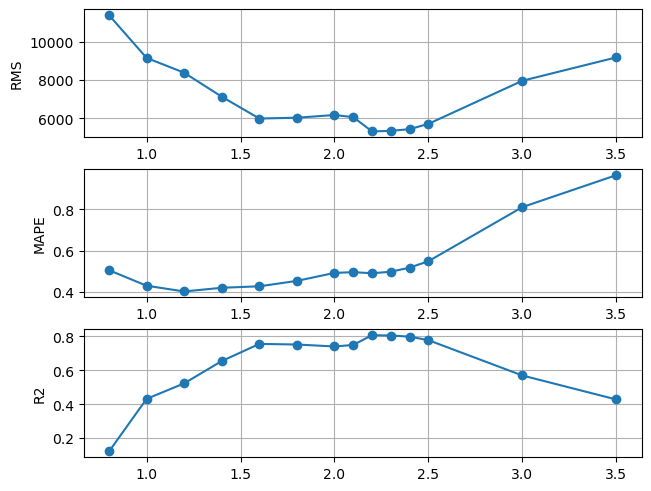

In [22]:
from sklearn.neighbors import RadiusNeighborsRegressor
import numpy as np

rn_r2list=[]
rn_mapelist=[]
rn_rmslist =[]

k = [0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.1,2.2,2.3,2.4,2.5,3.0,3.5]

for i in k:
    rnr_model = RadiusNeighborsRegressor(radius=i)
    rnr_model.fit(X=x_train_scaled, y=y_train)
    rnr_prediction = rnr_model.predict(X=x_test_scaled)
    rnr_prediction[np.isnan(rnr_prediction)] = 0

    rnr_rms = root_mean_squared_error(y_test, rnr_prediction)
    rn_rmslist.append(rnr_rms)

    rnr_mape = mean_absolute_percentage_error(y_test, rnr_prediction)
    rn_mapelist.append(rnr_mape)

    rnr_r2 = r2_score(y_test, rnr_prediction)
    rn_r2list.append(rnr_r2)


fig, axs = plt.subplots(3, 1, layout='constrained')
axs[0].plot(k, rn_rmslist, "-o")
axs[0].set_ylabel('radius')
axs[0].set_ylabel('RMS')
axs[0].grid(True)

axs[1].plot(k, rn_mapelist, "-o")
axs[1].set_ylabel('radius')
axs[1].set_ylabel('MAPE')
axs[1].grid(True)

axs[2].plot(k, rn_r2list, "-o")
axs[2].set_ylabel('radius')
axs[2].set_ylabel('R2')
axs[2].grid(True)
plt.show()


Aparentemente o melhor raio é 2.2

In [23]:
r_model_scaled = RadiusNeighborsRegressor(radius=2.2)

r_model_scaled.fit(X=x_train_scaled, y=y_train)
r_prediction_scaled = br_model_scaled.predict(X=x_test_scaled)

r_rms_scaled = root_mean_squared_error(y_test, r_prediction_scaled)
print(f"rms: {r_rms_scaled:.3f}")
r_mape_scaled = mean_absolute_percentage_error(y_test, r_prediction_scaled)
print(f"MAPE: {r_mape_scaled:.3f}")
r_r2_scaled = r2_score(y_test, r_prediction_scaled)
print(f"R2: {r_r2_scaled:.3f}")


rms: 5581.389
MAPE: 0.383
R2: 0.789


Praticamente todos os modelos atingiram aproximadamente as mesmas métricas

O melhor modelo entre os testados foi o KNeighborsRegressor com 12 vizinhos, mas qualquer outro poderia ser usado sem que houvesse grande diferença nos resultados